# Vorstellung verschiedener Oversampling-Methoden
Dieses Jupyter Notebook stellt verschiedene Oversampling-Methoden vor und zeigt deren Einfluss auf die Entscheidungsregionen von sechs verschiedenen Klassifikatoren anhand eines künstlichen Datensatzes.


#### Aufbau
- **Importieren aller benötigten Module und Funktionen.**
- **Definition verschiedener Funktionen.**
- **Einstellungen für die verwendeten Funktionen.**
- **Erstellung und Visualisierung des initialen Datensatzes und den Entscheidungsregionen sechs verschiedener Klassifikatoren.**
- **Oversampling des Datensatzes und Visualisierung der Effekte auf den Datensatz und die Entscheidungsregionen der Klassifikatoren.**
    - ***Random Oversampling***
    - ***SMOTE (Interpolation eines neuen Datenpunktes in einem Rechteck)***
    - ***SMOTE (Interpolation eines neuen Datenpunktes auf einer Verbindungslinie)***
    - ***Borderline SMOTE***
    - ***ADASYN***

Importieren aller benötigten Module und Funktionen

In [114]:
# Importierung der Oversampling Methoden
import pySMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE

# sklearn:
# Importieren der Funktion KNeighborsClassifier aus dem Modul sklearn.neighbors .
from sklearn.neighbors import KNeighborsClassifier
# Importieren der Funktion DecisionTreeClassifier aus dem Modul sklearn.tree .
from sklearn.tree import DecisionTreeClassifier
# Importieren der Funktion RandomForestClassifier aus dem Modul sklearn.ensemble .
from sklearn.ensemble import RandomForestClassifier
# Importieren der Funktion GaussianNB aus dem Modul sklearn.naive_bayes .
from sklearn.naive_bayes import GaussianNB

# Importieren der Funktion make_classification aus dem Modul sklearn.datasets .
from sklearn.datasets import make_classification

# mlxtend:
# Import um Entscheidungsregionen von Klassifikatoren zu zeichnen.
from mlxtend.plotting import plot_decision_regions
# Import um ein Streudiagramm zu zeichnen.
from mlxtend.plotting import category_scatter

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Graphen mit Plotly
import plotly.express as px

# Sonstiges:
import os
from collections import Counter
import numpy as np
import pandas as pd

Funktion um einen DataFrame mit 3 Spalten (`feature_1`, `feature_2` und `label` (Datentyp String)) zu erstellen. Die Spalte `label` wird in den Datentyp String umgewandelt, damit die Legende von plotly diskret angezeigt wird.

In [115]:
def to_df(X,y):
    df_x = pd.DataFrame(X)
    df_y = pd.DataFrame(y)

    df = pd.concat([df_x, df_y], axis=1, join="inner")
    df.columns = ['feature_1', 'feature_2', 'label']
    df['label'] = df['label'].astype(str)
    return df

Funktionen um einen Datensatz in einem 2D Streudiagramm zu visualisieren und abzuspeichern.

In [116]:
# Funktion zur Abspeicherung von Bildern mit plotly für die Visualisierung von Random Oversampling.
# filename legt den Namen des abgespeicherten Bildes fest.
# fig_extension legt den Datentyp des abgespeicherten Bildes fest.
# Eine vergrößerte Darstellung eines Datenpunkts ist durch einstellen von `size` möglich.
def visualize_save(filename, fig_extension="png", f1='feature_1', f2='feature_2', color="label", width=700, height=500, size=None):
    # Anlegen des Scatterplots. Die Farben (color_discrete_sequence) und die Symbole (symbol_sequence) werden in der Reihenfolge der category_orders verwendet.
    fig = px.scatter(df, x=f1, y=f2, color=color, width=width, height=height, size=size, color_discrete_sequence=['Blue', 'DarkOrange', 'DarkGreen'], symbol=color, symbol_sequence=[ 'square', 'triangle-up', 'triangle-down'], category_orders={"label": ["0", "1", "syn"]})
    # Festlegen der Hintergrundfarbe des Graphen.
    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)")
    # Festlegen der Farben des Koordinatensystems.
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='DarkGrey')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='DarkGrey')
    fig.update_traces(marker=dict(line=dict(width=0.5, color='DarkSlateGrey')), selector=dict(mode='markers'))
    # Festlegen des Dateipfades für das Abspeichern.
    path = os.path.join(IMAGES_PATH, filename + "." + fig_extension)
    # Abspeichern des Graphen.
    print("Saving figure", filename)
    fig.write_image(path, width=width, height=height)
    # Anzeigen des Graphen.
    fig.show()

# Funktion zur Abspeicherung von matplotlib Bildern.
# fig_id legt den Namen des abgespeicherten Bildes fest.
# tight_layout passt automatisch die Größe mehrerer untergeordneter Graphen an, damit diese sich nicht überschneiden.
# fig_extension legt den Datentyp des abgespeicherten Bildes fest.
# resolution bestimmt die Auflösung des Bildes.
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "2." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Funktion zur Visualisierung und Abspeicherung von Graphen mit Mlxtend.
def visualize_save2(filename, f1='feature_1', f2='feature_2', label_col="label", width=2000, height=1000, size=None):
    # Initalisierung des Streudiagramms
    category_scatter(f1, f2,label_col=label_col, data=df, markers='s^v', markersize=20.0, colors=('blue', '#ff7700', 'green'))
    # Abspeichern des Bildes
    save_fig(filename)
    # Anzeigen des Bildes.
    plt.show()

Funktion um mit Imblearn zu oversamplen. Der random_state wird für jede Oversampling-Methode für reproduzierbare Ergebnisse auf 42 gesetzt. Die Zahl der Nachbarn welche bei der Erzeugung eines synthetischen Datenpunktes berücksichtigt werden, ist auf 5 initialisiert und kann bei Bedarf abgeändert werden. Die Funktionen geben allesamt Attributsausprägungen und Klassenzuordungen zurück, in denen die neuen Datenpunkte bereits mit inbegriffen sind.

In [117]:
def imblearn_oversampling(oversampler, X, y, random=42, neighbors=5):
    if oversampler=='ros':
        ros = RandomOverSampler(random_state=random)
        X_res, y_res = ros.fit_resample(X, y)
    if oversampler=='sm':
        sm = SMOTE(random_state=random, k_neighbors=neighbors)
        X_res, y_res = sm.fit_resample(X, y)
    if oversampler=='bsm':
        sm = BorderlineSMOTE(random_state=random, k_neighbors=neighbors)
        X_res, y_res = sm.fit_resample(X, y)
    if oversampler=='ada':
        ada = ADASYN(random_state=random, n_neighbors=neighbors)
        X_res, y_res = ada.fit_resample(X, y)


    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

Funktion um sechs verschiedene Klassifikatoren zu intitialisieren, trainieren und Entscheidungsregionen darzustellen

In [118]:
def plot_dec_regs(X_train, y_train, identifier):
    classifier_list= [
        # Initialisieren des DecisionTreeClassifier mit dem Blatt-Aufspaltungskriterium 'gini' und dem random_state=42 um reproduzierbare Ergebnisse zu ermöglichen.
        DecisionTreeClassifier(criterion='gini', random_state=42),
        # Initialisieren des DecisionTreeClassifier mit dem Blatt-Aufspaltungskriterium 'entropy' und dem random_state=42 um reproduzierbare Ergebnisse zu ermöglichen.
        DecisionTreeClassifier(criterion='entropy', random_state=42),
        # Initialisieren eines RandomForestClassifier.
        # n_estimators=10 bedeutet, dass 10 Bäume erzeugt werden, welche das Voting übernehmen.
        # max_leaf_nodes=16 bedeutet, dass ein einzelner Baum der erzeugt wird, maximal 16 Blattknoten besitzen darf.
        # Festlegen des random_state auf 42 damit das Ergebnis reproduzierbar bleibt.
        # n_jobs=-1 bedeutet, dass für die Berechnungen alle Kerne des CPU genutzt werden (-> schneller).
        # criterion='entropy' legt Gini als Kriterium zur Aufspaltung der Knoten in den Entscheidungsbäumen fest.
        RandomForestClassifier(n_estimators=10, max_leaf_nodes=16, random_state=42, n_jobs=-1, criterion='gini'),
        # Initialisieren eines RandomForestClassifier.
        # n_estimators=10 bedeutet, dass 10 Bäume erzeugt werden, welche das Voting übernehmen.
        # max_leaf_nodes=16 bedeutet dass ein einzelner Baum der erzeugt wird, maximal 16 Blattknoten besitzen darf.
        # Festlegen des random_state auf 42 damit das Ergebnis reproduzierbar bleibt.
        # n_jobs=-1 bedeutet, dass für die Berechnungen alle Kerne des CPU genutzt werden (-> schneller).
        # criterion='entropy' legt die Entropie als Kriterium zur Aufspaltung der Knoten in den Entscheidungsbäumen fest.
        RandomForestClassifier(n_estimators=10, max_leaf_nodes=16, random_state=42, n_jobs=-1, criterion='entropy'),
        # Initialisieren des KNeighborsClassifier.
        # n_neighbors=5 bedeutet, dass für die Klassierung eines Punktes die Information von 5 Nachbarn beachtet wird.
        # n_jobs=-1 bedeutet, dass für die Berechnungen alle Kerne des CPU genutzt werden (-> schneller).
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
        # Initialisieren eines Gaussian Naive Bayes.
        GaussianNB(),
    ]


    labels = [
              'Decision_Tree_Gini',
              'Decision_Tree_Entropy',
              'Random_Forest_Gini',
              'Random_Forest_Entropy',
              'K_Nearest_Neighbors',
              'Gaussian_Naive_Bayes'
              ]


    # Iteration über alle Klassifikatoren und Zeichnen der Abbildungen
    gs = gridspec.GridSpec(3, 2)

    fig = plt.figure(figsize=(10,12))


    for clf, lab, grd in zip(classifier_list,
                             labels,
                             [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]):

        clf.fit(X_train, y_train)
        ax = plt.subplot(gs[grd[0], grd[1]])
        fig = plot_decision_regions(X=X_train, y=y_train, clf=clf, legend=2)
        plt.title(lab)

    save_fig('bsp_plot_classifiers_dec_regs_' + identifier)
    plt.show()

Funktion um aus einem Datensatz (bestehend aus den Attributsausprägungen X und den Klassenzuordnungen y) alle Elemente einer Klasse herauszufiltern. In diesem Fall wird die Funktion dazu genutzt die Minderheit herauszufiltern und die Mehrheit zu entfernen.

In [119]:
def filter_minority(X, y, majority_class_str):
    df = to_df(X, y)
    i=0
    index_list=[]
    while i<len(df):
        if df['label'][i]==majority_class_str:
            index_list.append(i)
        i +=1
    index_list
    df.drop(index_list, inplace=True)
    df.drop(columns=['label'], inplace=True)
    df = df.to_numpy()
    return df

Methode um die Anwendung von pySMOTE an die Verwendung der restlichen Oversampling-Methoden anzugleichen

In [120]:
def custom_oversampling(X ,y, minority_class, majority_class_str, ratio=None, neighbors=5):

    minority = filter_minority(X, y, majority_class_str)

    # Formel, um die Menge an neu zu generierenden Punkten auf eine Anzahl zu erhöhen, welche die Anteile beider Klassen im Datensatz auf 50% setzt.
    if ratio is not None:
        ratio=ratio
    else:
        ratio = int(((len(y)/len(minority)) - 1)*100)
        subtraction = int(((len(y)/len(minority)) - 1)*100)%100
        ratio-=subtraction

    # Initialisierung und Anwendung der Funktion SMOTE aus dem Modul pySMOTE auf die Minderheit des Trainingsdatensatzes
    smote = pySMOTE.SMOTE(ratio=ratio, k_neighbors=neighbors)
    new_samples = smote.oversample(minority)
    new_samples = pd.DataFrame(new_samples)

    # Anlegen einer Spalte für die Klassenzugehörigkeiten der neuen Datenpunkte
    if minority_class==1:
        label_column = pd.DataFrame(1, index=np.arange(len(new_samples)), columns=['label'])
    else:
        label_column = pd.DataFrame(0, index=np.arange(len(new_samples)), columns=['label'])
    new_samples.insert(2, 'label', label_column, True)

    # Zusammenführung des alten Datensatzes mit den neu generierten Datenpunkten
    df = to_df(X, y)
    df = df.to_numpy()
    new_samples = new_samples.to_numpy()
    df = np.concatenate((df, new_samples))
    df = pd.DataFrame(df)

    df.columns = ['feature_1', 'feature_2', 'label']
    df['label'] = df['label'].astype(str)

    i=0
    while i<len(df):
        if df['label'][i]=='1.0':
            df['label'][i]='syn'
        if df['label'][i]=='0.0':
            df['label'][i]='syn'
        i +=1
    # Rückgabe des Datensatzes, welcher nun die zusätzlich generierten Datenpunkte mit der Beschriftung 'syn' enthält.
    return df

##### Einstellungen für die verschiedenen Funktionen
Erstellung eines Speicherorts für die Graphen.

In [121]:
# Erstellung eines Speicherort für die Graphen
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "os_bsp_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

##### Erstellung und Visualisierung des initialen Datensatzes
Erstellung eines synthetischen Datensatzes.

In [122]:
X, y = make_classification(n_classes=2, class_sep=5,
                           weights=[0.1, 0.9], n_informative=2, n_redundant=0, flip_y=0,
                           n_features=2, n_clusters_per_class=1, n_samples=300, random_state=42, hypercube=False)

print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 270, 0: 30})


Vertauschen der Klassenzuordnungen für einen besser erkennbaren Effekt der Oversampling-Methoden.

In [123]:
i=0
while i<len(y):
    if y[i]==0:
        y[i]=2
    i+=1
i=0
while i<len(y):
    if y[i]==1:
        y[i]=0
    else:
        y[i]=1
    i+=1

Datensatz in Dataframe überführen für die weitere Verwendung.

In [124]:
df = to_df(X,y)

Initialen Datensatz in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_initial


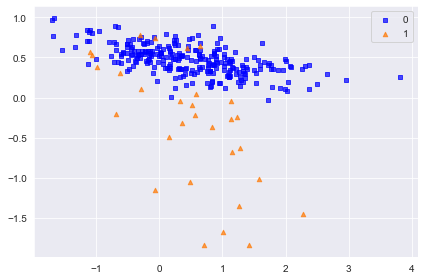

In [125]:
visualize_save2('bsp_plot_initial')

Entscheidungsregionen des initialen Datensatzes für jeden der sechs Klassifikatoren in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_classifiers_dec_regs_initial


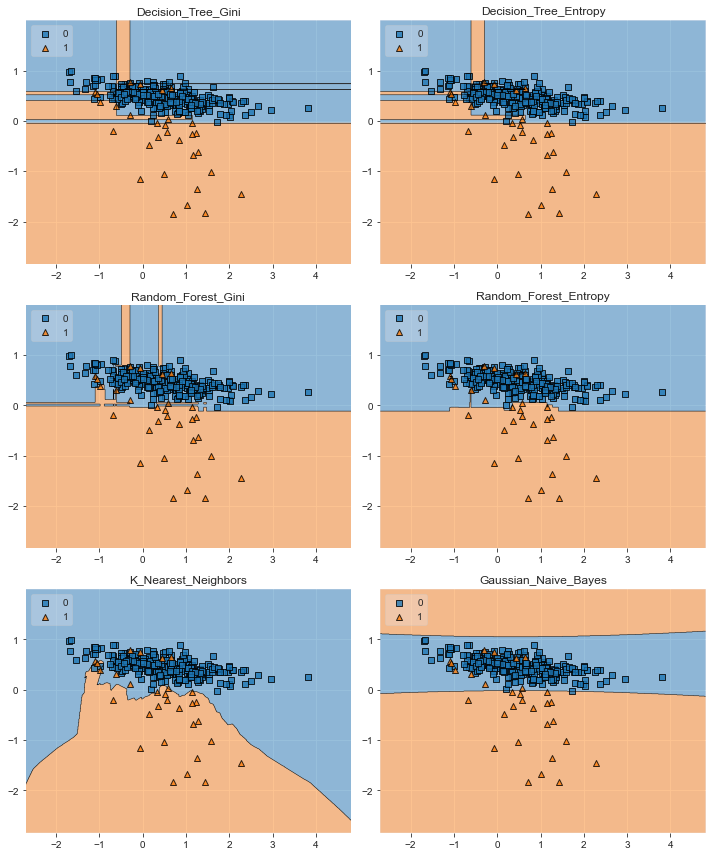

In [126]:
plot_dec_regs(X,y,'initial')

Datensatz mit Random Oversampler oversamplen.

In [127]:
X_res, y_res = imblearn_oversampling('ros', X, y)

Resampled dataset shape Counter({0: 270, 1: 270})


Datensatz in Dataframe überführen

In [128]:
df = to_df(X_res, y_res)

Die nachfolgenden Zellen ermitteln die vielfachen Datenpunkte, speichern die Anzahl als zusätzliche Spalte ab und löschen die vielfachen Datenpunkte, damit die durch ROS erzeugten vielfachen Datenpunkte veranschaulicht werden können.

Dataframe nach `feature_1` aufsteigend sortieren und Index zurücksetzen.

In [129]:
df = df.sort_values(by='feature_1')
df = df.reset_index(drop=True)

Doppelte Datenpunkte zählen und eine Liste mit der Anzahl an Datenpunkten erstellen.

In [130]:
counter=0
counter_list=[]
first_entry = df['feature_1'][0]
for feature in df['feature_1']:
    if feature==first_entry:
        counter = counter + 1
    else:
        counter_list.append(counter)
        counter = 1
        first_entry=feature
counter_list.append(counter)

Entfernen der Duplikate.

In [131]:
df = df.drop_duplicates(subset=['feature_1', 'feature_2'])

Anzahl als zusätzliche Spalte hinzufügen.

In [132]:
df.insert(3, "number", counter_list, True)

Datensatz nach Random Oversampling in einem Streudiagramm anzeigen lassen und abspeichern. Die Anzahl an Datenpunkten wird dabei mit der Größe der Punkte skaliert.

In [133]:
visualize_save('bsp_plot_ros', size='number')

Saving figure bsp_plot_ros


Entscheidungsregionen des Datensatzes nach Random Oversampling für jeden der sechs Klassifikatoren in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_classifiers_dec_regs_ros


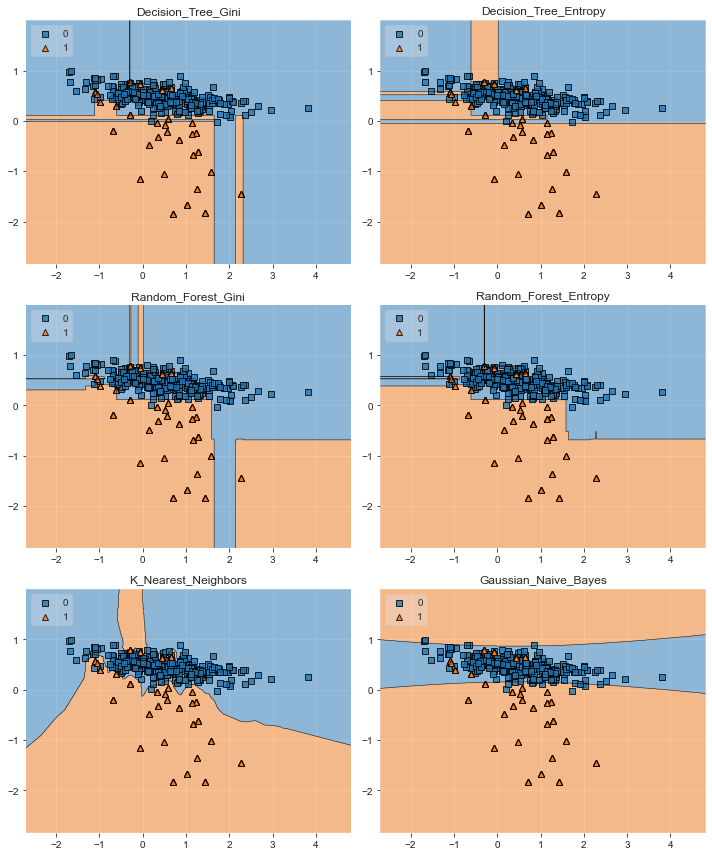

In [134]:
plot_dec_regs(X_res, y_res, 'ros')

Auf den Datensatz SMOTE mit der Interpolationsvariante Rechteck anwenden.

In [135]:
df = custom_oversampling(X, y, 1, '0', ratio=800)

Datensatz nach dem Oversampling in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_sm_fixed


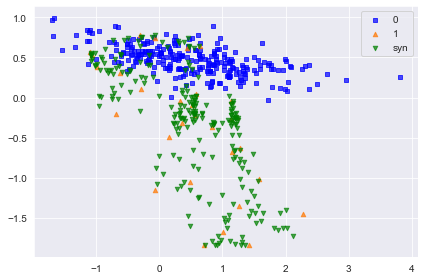

In [136]:
visualize_save2('bsp_plot_sm_rectangle')

Umwandlung der Klassenzuordnung 'syn' zu '1' um die Entscheidungsregionen darstellen zu können.

In [137]:
df.loc[len(y):,'label'] = '1'

Vereinheitlichung der Attributsausprägungen und Klassenzugeörigkeiten auf einen jeweiligen Datentyp zur Visualisierung der Entscheidungsregionen.

In [138]:
features = df[['feature_1', 'feature_2']]
features_np = features.to_numpy()
features_np = features_np.astype(float)

labels = df['label']
labels_np = labels.to_numpy()
labels_np = labels_np.astype(int)

Entscheidungsregionen des Datensatzes nach SMOTE mit der Interpolationsvariante Rechteck für jeden der sechs Klassifikatoren in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_classifiers_dec_regs_sm_fixed


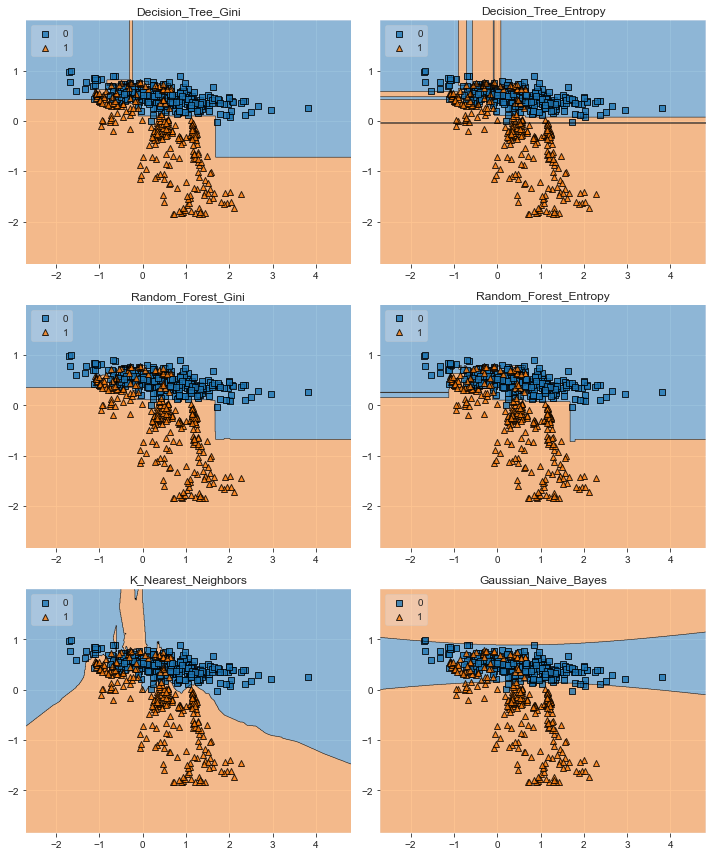

In [139]:
plot_dec_regs(features_np, labels_np, 'sm_rectangle')

Auf den Datensatz SMOTE mit der Interpolationsvariante Verbindungslinie anwenden.

In [140]:
X_res, y_res = imblearn_oversampling('sm', X, y)

Resampled dataset shape Counter({0: 270, 1: 270})


Datensatz in Dataframe überführen.

In [141]:
df = to_df(X_res, y_res)

Umwandlung der Klassenzuordnung 'syn' zu '1' um die Entscheidungsregionen darstellen zu können.

In [142]:
df.loc[len(y):len(y_res)-1,'label'] = 'syn'

Datensatz nach dem Oversampling in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_sm


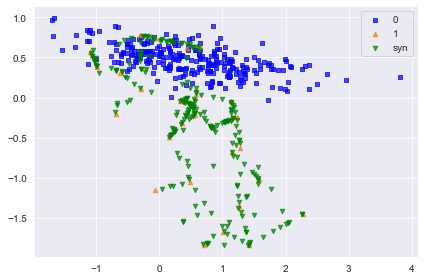

In [143]:
visualize_save2('bsp_plot_sm')

Entscheidungsregionen des Datensatzes nach SMOTE mit der Interpolationsvariante Verbindungslinie für jeden der sechs Klassifikatoren in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_classifiers_dec_regs_sm


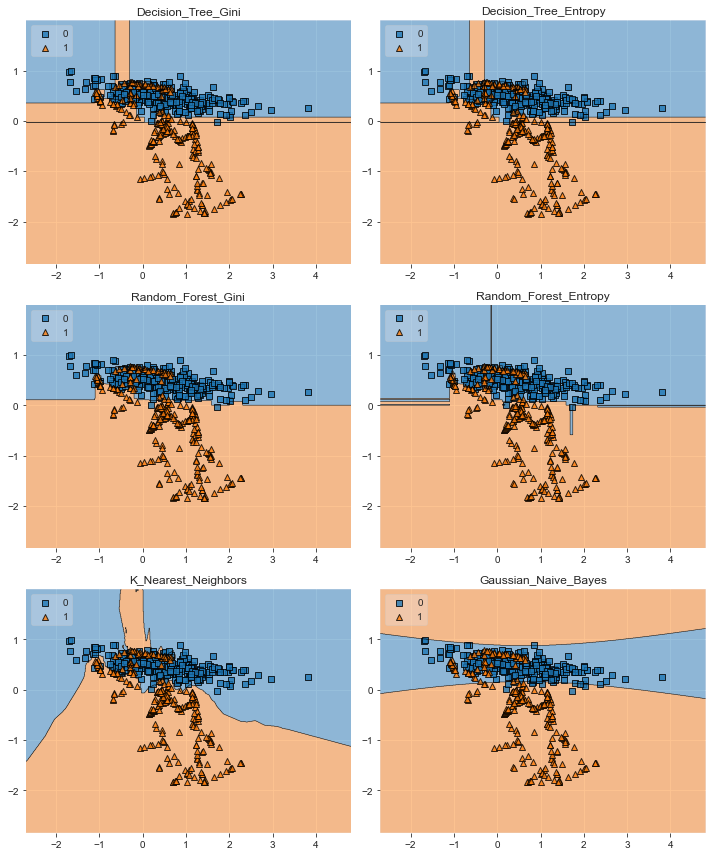

In [144]:
plot_dec_regs(X_res, y_res, 'sm')

Datensatz mit Borderline SMOTE oversamplen.

In [145]:
X_res, y_res = imblearn_oversampling('bsm', X, y)

Resampled dataset shape Counter({0: 270, 1: 270})


Datensatz in DataFrame überführen.

In [146]:
df = to_df(X_res, y_res)

Umwandlung der Klassenzuordnung 'syn' zu '1' um die Entscheidungsregionen darstellen zu können.

In [147]:
df.loc[len(y):len(y_res)-1,'label'] = 'syn'

Datensatz nach dem Oversampling in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_bsm


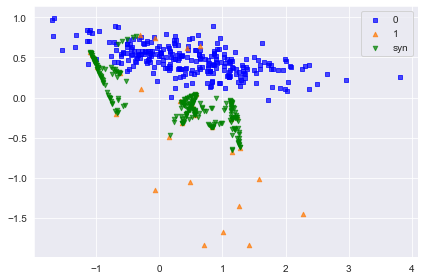

In [148]:
visualize_save2('bsp_plot_bsm')

Entscheidungsregionen des Datensatzes nach ADASYN für jeden der sechs Klassifikatoren in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_classifiers_dec_regs_bsm


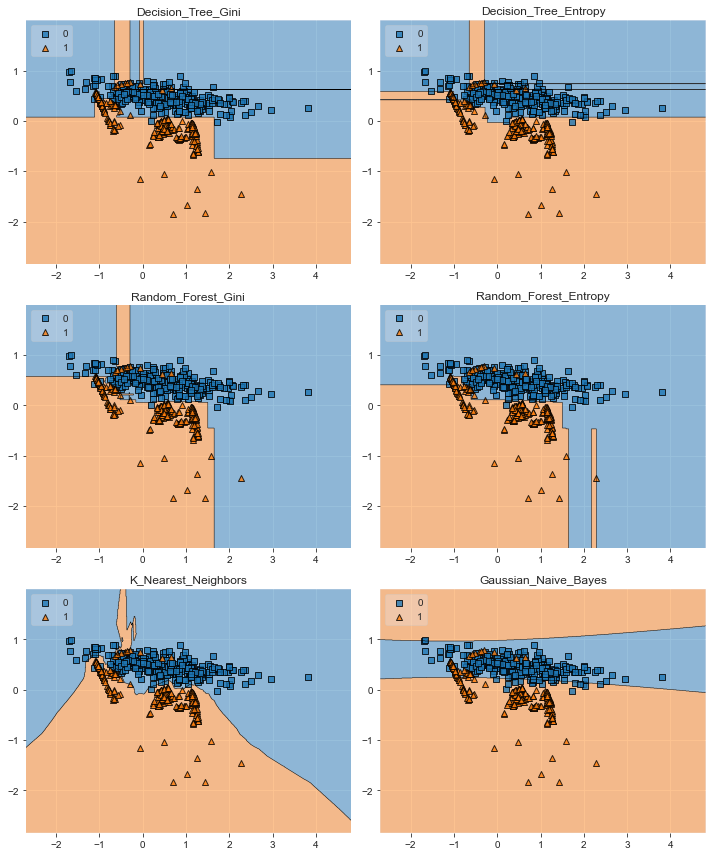

In [149]:
plot_dec_regs(X_res, y_res, 'bsm')

Auf den Datensatz ADASYN anwenden.

In [150]:
X_res, y_res = imblearn_oversampling('ada', X, y)

Resampled dataset shape Counter({0: 270, 1: 270})


Datensatz in Dataframe überführen.

In [151]:
df = to_df(X_res, y_res)

Umwandlung der Klassenzuordnung 'syn' zu '1' um die Entscheidungsregionen darstellen zu können.

In [152]:
df.loc[len(y):len(y_res)-1,'label'] = 'syn'

Datensatz nach dem Oversampling in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_ada


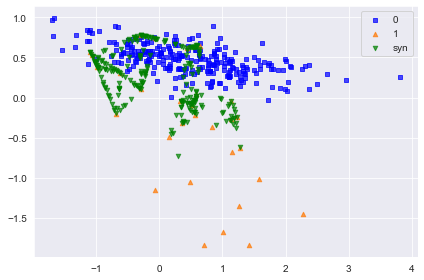

In [153]:
visualize_save2('bsp_plot_ada')

Entscheidungsregionen des Datensatzes nach ADASYN für jeden der sechs Klassifikatoren in einem Streudiagramm anzeigen lassen und abspeichern.

Saving figure bsp_plot_classifiers_dec_regs_ada


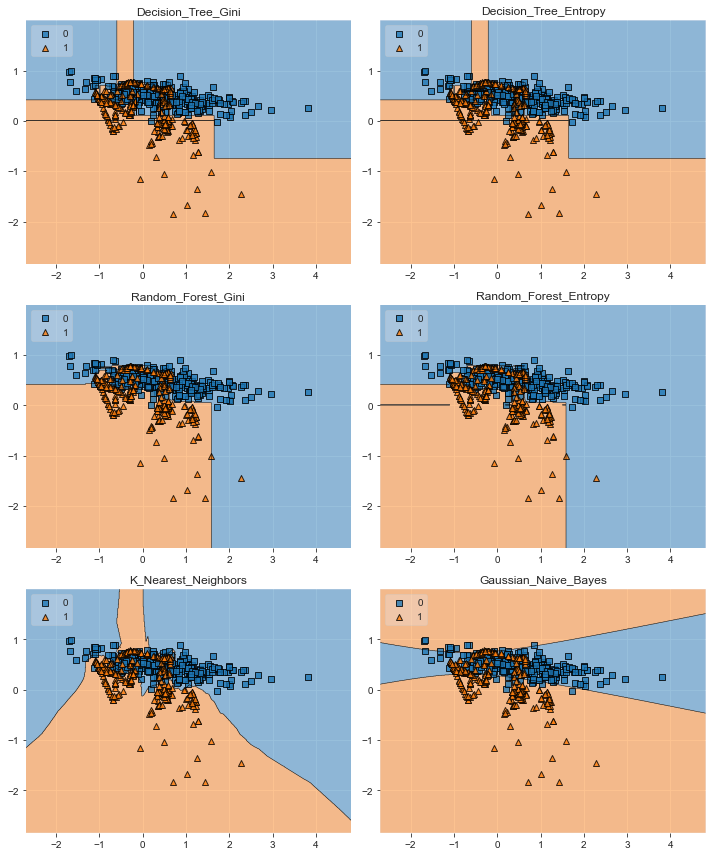

In [154]:
plot_dec_regs(X_res, y_res, 'ada')